<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1">Preparation</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-2">Analysis</a></span><ul class="toc-item"><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-2.1">Conclusion</a></span></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-3">Train</a></span><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-3.1">Data preparation</a></span></li><li><span><a href="#Model-selection,-training" data-toc-modified-id="Model-selection,-training-3.2">Model selection, training</a></span></li></ul></li><li><span><a href="#Testing" data-toc-modified-id="Testing-4">Testing</a></span></li><li><span><a href="#SARIMAX" data-toc-modified-id="SARIMAX-5">SARIMAX</a></span></li><li><span><a href="#SARIMAX-TEST" data-toc-modified-id="SARIMAX-TEST-6">SARIMAX TEST</a></span><ul class="toc-item"><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6.1">Conclusion</a></span></li></ul></li></ul></div>

#  Forecasting taxi orders

The company has collected historical data on taxi orders at airports. We need to predict the number of taxi orders for the next hour to attract more drivers during the peak period. Build a model for such a prediction.

The value of the *RMSE* metric on the test set should not exceed 48.

We need:

1. Load the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on the test sample and conclude.


The data is in the `taxi.csv` file. The number of orders is in the `num_orders` column.

## Preparation

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.statespace import sarimax

import scipy.stats as scs

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression as lr
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgb

import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class bcolors:
    CYAN = '\033[96m'
    FAIL = '\033[91m'
    END = '\033[0m'

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Uploading a document. We use the time column as an index, sort the data in ascending time, look at the completeness and purity of the data
</div>

In [2]:
data = pd.read_csv("taxi.csv",parse_dates =[0],index_col= 0)


In [3]:
data = data.sort_index()
if data.index.is_monotonic == True: message = 'monotonic'
else:  message = 'not monotonic'
display(message, data.head())

'monotonic'

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Everything is in order with the data, there are no gaps, they are monotonous, there are no outliers either. Let's resample the time by one hour, let's see how the size of the dataset has changed. After that, let's move on to the analysis.
</div>

In [5]:
data = data.resample("1H").sum()

In [6]:
data.shape

(4416, 1)

## Analysis

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
Let's look at the following time series values:
    
- Moving average - experimentally select the size of the window in which we perform the averaging. Let's smooth out short-term fluctuations and highlight trends or cycles.
- Let's analyze trends and seasonality.
- Check the time series for stationarity.
- Let's shift and look at stationarity again
    
</div>

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Moving average
</div>

In [7]:
data_copy = data.copy()
df = data.copy()

In [8]:
data["rolling_mean"] = data["num_orders"].rolling(24).mean()
data["rolling_std"] = data["num_orders"].rolling(24).std()

<AxesSubplot:xlabel='datetime'>

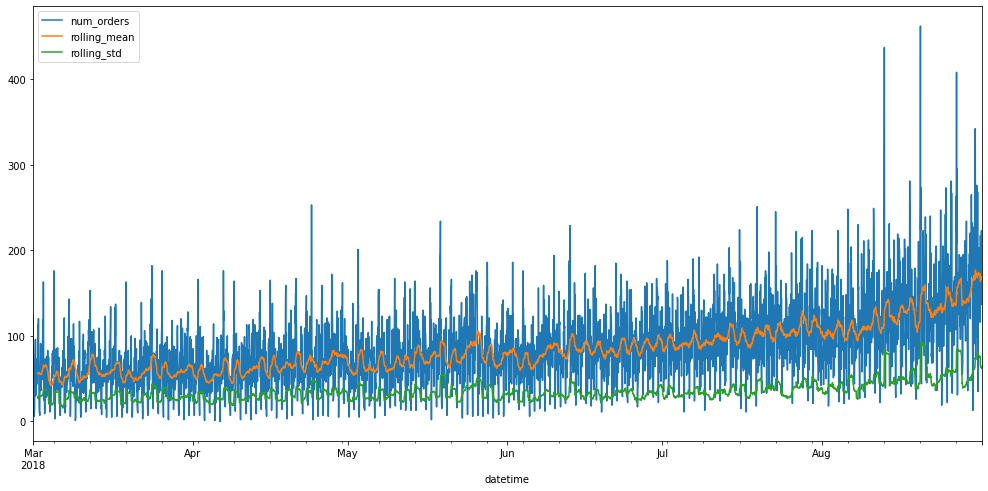

In [9]:
figsize = (17,8)
data.plot(figsize=figsize)

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Series stationarity
</div>

In [10]:
p_value = adfuller(data['num_orders'])[1]
print('P =', p_value)
if p_value < 0.05:
    print(f'{bcolors.CYAN}The series is stationary by the Dickey-Fuller criterion{bcolors.END}')
else:
    print(f'{bcolors.FAIL}The series is not stationary according to the Dickey-Fuller criterion{bcolors.END}')

P = 0.02894005140261345
The series is stationary by the Dickey-Fuller criterion


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

The time series is stationary.
</div>

In [11]:
data_shift = data - data.shift(18)

In [12]:
data_shift["rolling_mean"] = data_shift["num_orders"].rolling(24).mean()
data_shift["rolling_std"] = data_shift["num_orders"].rolling(24).std()

Text(0.5, 1.0, 'Time series with a shift')

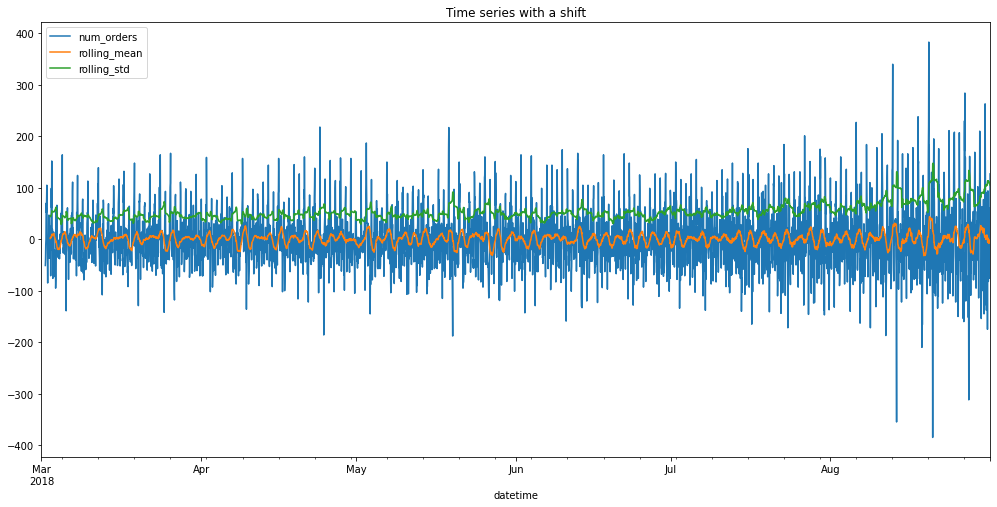

In [13]:
data_shift.plot(figsize = figsize)
plt.title('Time series with a shift')

In [14]:
p_value = adfuller(data_shift['num_orders'].dropna())[1]
print('P =', p_value)
if p_value < 0.05:
    print('The null hypothesis is rejected. The series is stationary by the Dickey-Fuller criterion')
else:
    print('The null hypothesis is not rejected. The series is not stationary according to the Dickey-Fuller criterion')

P = 0.0
The null hypothesis is rejected. The series is stationary by the Dickey-Fuller criterion


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
We have data from March to the end of August.
    
Let's look at trends and seasonality.
    
- During all this time
- Last full week (Monday to Monday)
- For every month
- Separately, let's look at the trends of the first full three weeks of each month.
</div>

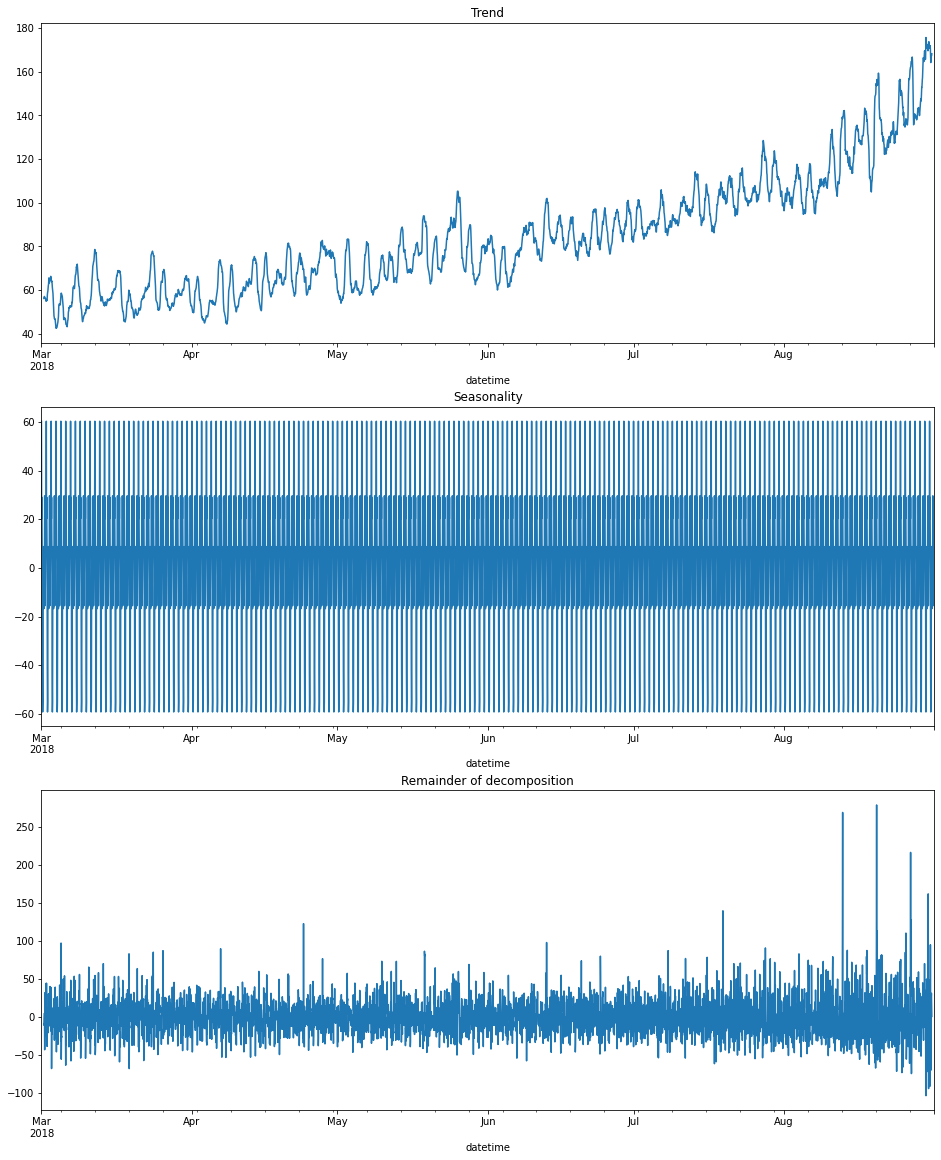

In [15]:
# За всё время
decomposed = seasonal_decompose(df)
def make_plot(trend,seasonal,resid):
    fig,ax = plt.subplots(3,1, figsize = (16,20) )

    trend.plot(ax=ax[0],title = 'Trend')
    seasonal.plot(ax=ax[1],title = 'Seasonality')
    resid.plot(ax=ax[2],title = 'Remainder of decomposition')
    
make_plot(decomposed.trend,decomposed.seasonal,decomposed.resid )

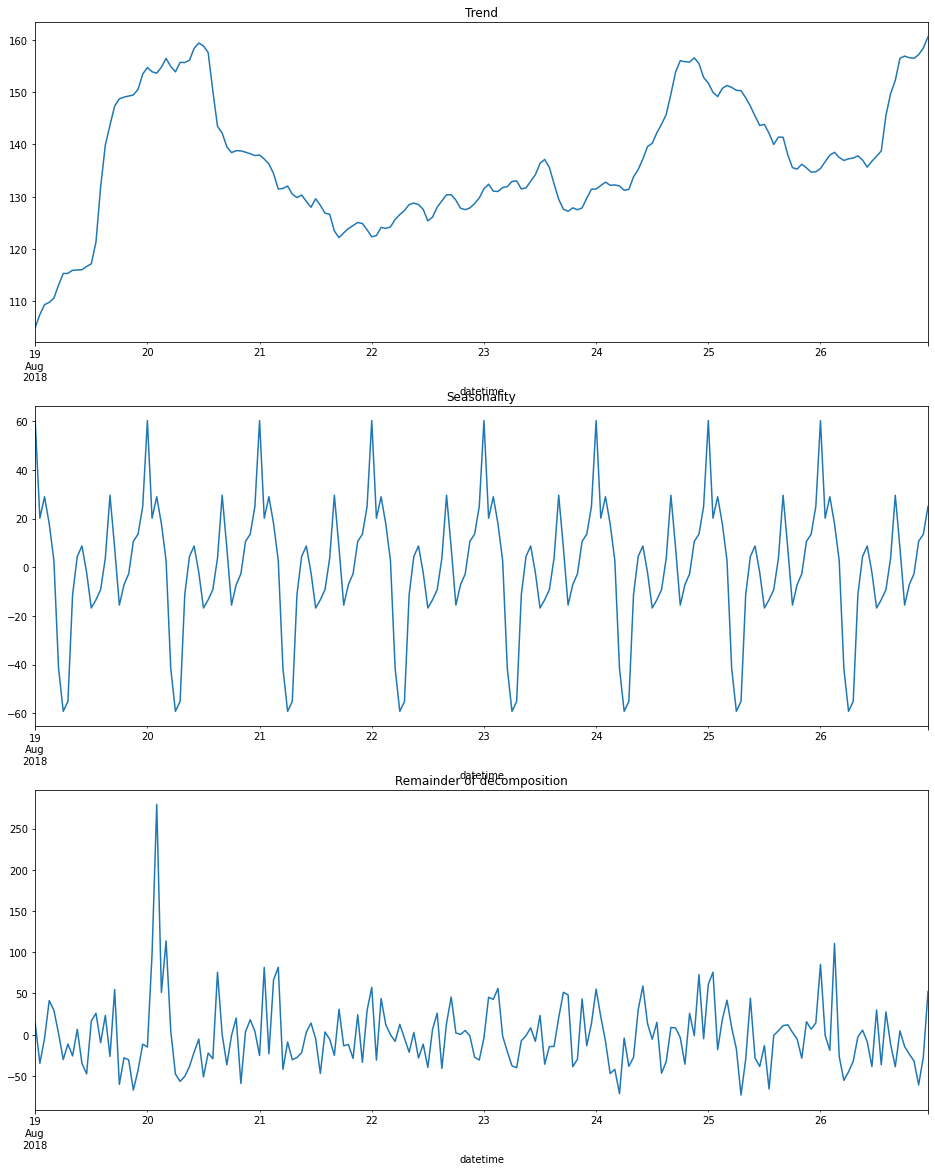

In [16]:
# From Monday to Monday of the last month
make_plot(decomposed.trend['2018-08-19':'2018-08-26'],
          decomposed.seasonal['2018-08-19':'2018-08-26'],
          decomposed.resid['2018-08-19':'2018-08-26'] )

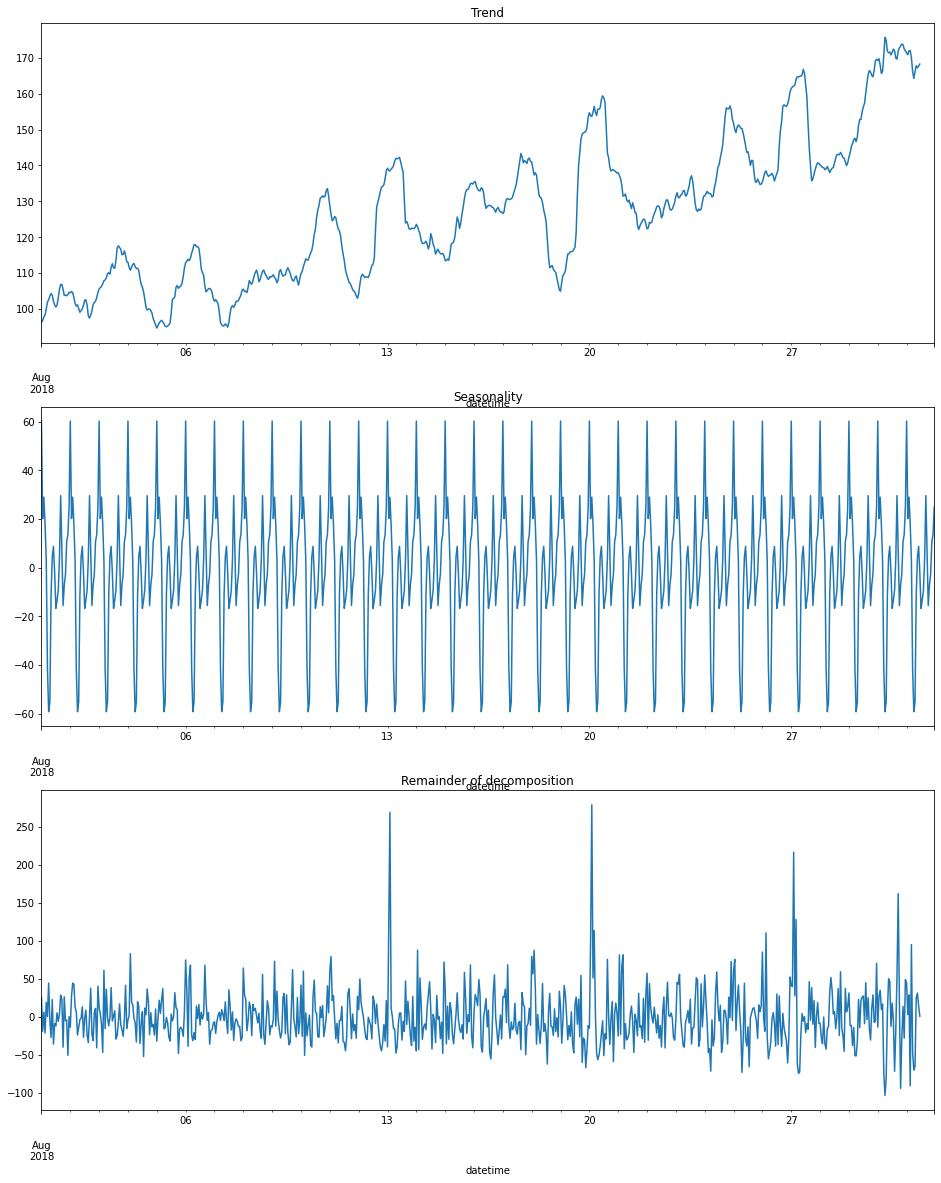

In [17]:
# Data for the last month - August
make_plot(decomposed.trend[-24*31:],
          decomposed.seasonal[-24*31:],
          decomposed.resid[-24*31:] )

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Let's look separately at the trends of the first full three weeks (from Mon to Mon) of each month to understand if there is a pattern depending on the day of the week and whether it changes depending on the month.
</div>

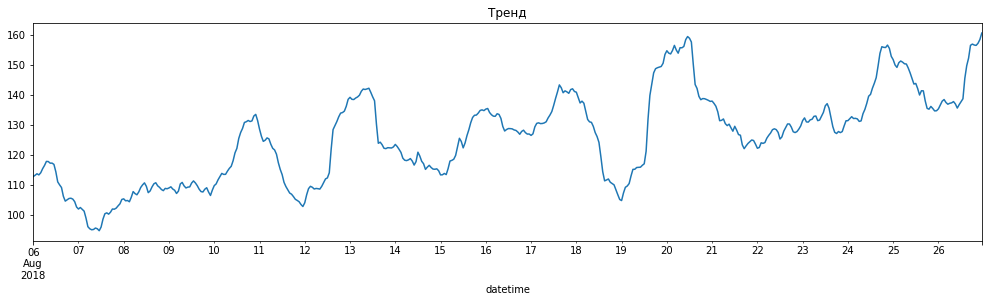

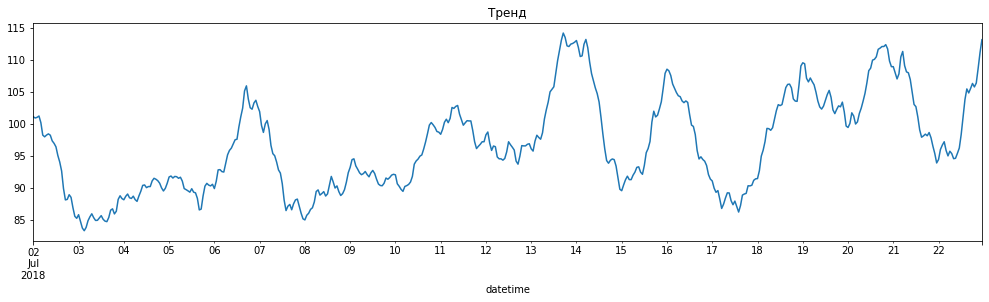

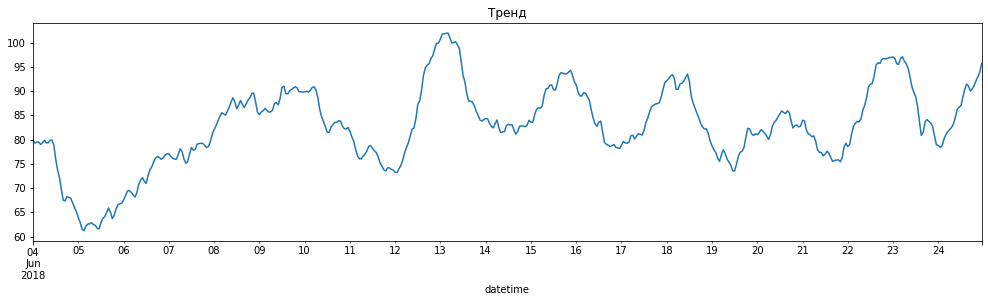

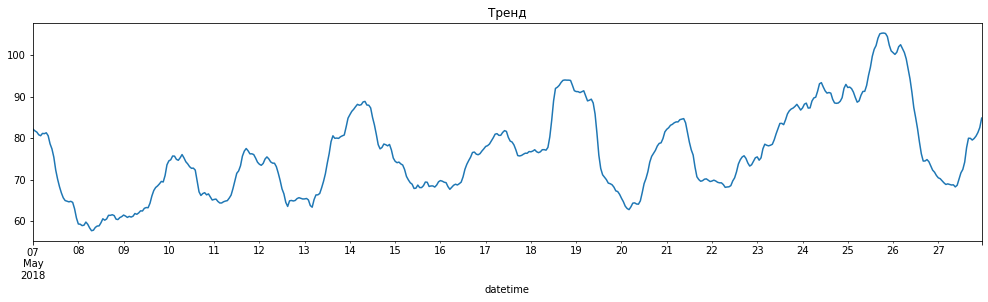

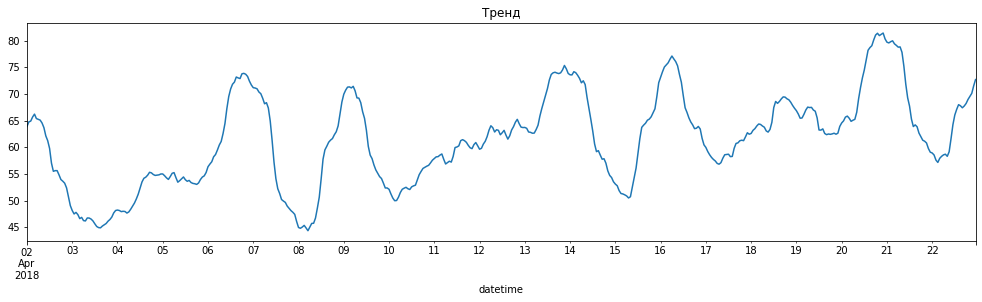

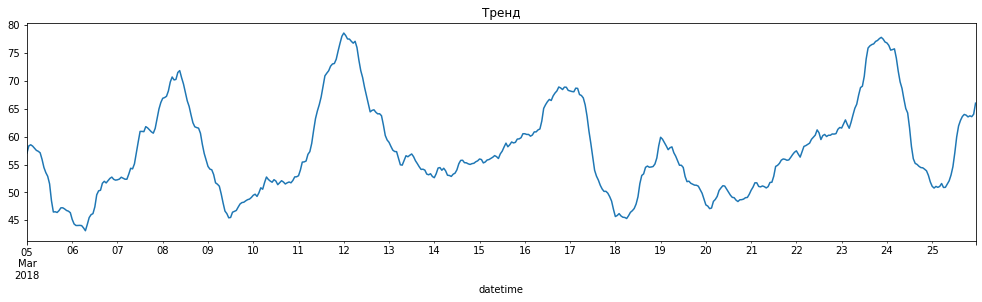

In [18]:
def trend_all_months(trend):
    trend.plot(title = 'Тренд',figsize=(17,4))    
    plt.show()
    
# First full 3 weeks of each month
trend_all_months(decomposed.trend['2018-08-06':'2018-08-26'])
trend_all_months(decomposed.trend['2018-07-02':'2018-07-22'])
trend_all_months(decomposed.trend['2018-06-04':'2018-06-24'])
trend_all_months(decomposed.trend['2018-05-07':'2018-05-27'])
trend_all_months(decomposed.trend['2018-04-02':'2018-04-22'])
trend_all_months(decomposed.trend['2018-03-05':'2018-03-25'])


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
    
### Conclusion
    
    
At first glance, the time rad is non-stationary because it has a noticeable upward trend in the average value from month to month. The popularity of calling a taxi has grown over the past six months, which is good news. In this case, the series is stationary according to the Dickey-Fuller criterion (0.029). So the series is stationary.
The following trends are noticeable on the taxi call charts:
- Monthly trend: every month, the average value gradually increases. Growing brand awareness
- Weekly cycle: Each week is similar to the previous one, with peak values on Monday, Friday, and Sunday, most likely due to regular flights at the airport and the congestion of public transport these days.
- Daily seasonality: decline in the morning and rise towards night (just like my brain activity), most likely due to the availability of public transport at this time. In the morning, it is free; in the afternoon, the choice is between rush hour and an expensive taxi; at night, the situation is hopeless, and people call a cab.

Considering the above conclusions, let's take the month, day, and week as additional features. Considering that the time series is divided into hours, there is no need to take the hour as a separate feature.
    
</div>

## Train

### Data preparation

In [19]:
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek

# Making features
def make_features(df, max_lag, rolling_mean_size):
    new_df = df.copy(deep = True)
    for lag in range(1, max_lag + 1):
        new_df[f'lag_{str(lag)}'] = new_df['num_orders'].shift(lag)

    new_df['rolling_mean'] = new_df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_df

def rmse(predict, actual):
    return np.sqrt(mse(predict, actual))
    
def make_train_n_test(df):
    final_df = df.dropna()
    train,test = train_test_split(final_df,shuffle = False, random_state = 12345, test_size = 0.1)
    train_features,test_features = train.drop('num_orders',axis = 1),test.drop('num_orders',axis = 1)
    train_target,test_target = train['num_orders'],test['num_orders']
    return train_features,test_features,train_target,test_target

In [20]:
rolling_mean_size = 24*7

max_lag = 24

In [21]:
# This table will record the results of our models
results = pd.DataFrame({'Model' : [], 
                        'Cross-validation RMSE' : [], 
                        'RMSE train' : [], 
                        'Train time' : []})

In [22]:
# Remove unnecessary
del data
del data_shift
del data_copy
del decomposed

### Model selection, training

In [23]:
# Linear regressions
line = lr()

# Decision Tree Regressor
tree = DecisionTreeRegressor(random_state=12345, max_depth=5)

# Gradient Boosting Regressor
gb = GradientBoostingRegressor(random_state=12345, n_estimators=100, learning_rate=0.25)

# eXtra Gradient Boosting Regressor
xgbr = xgb.XGBRegressor(learning_rate=0.1, n_estimators=100, verbosity = 0)

# CatBoost Regressor
cat = CatBoostRegressor(verbose=False)

# Light Gradient Boosting Model Regressor 
lgbr = lgb.LGBMRegressor(objective='root_mean_squared_error')
lgb_params = {'learning_rate': [0.25],
              'max_depth' : [i for i in range(-1,8)],
              'num_leaves' : [i for i in range(2,6,1)],
              'n_estimators' : [i for i in range(80,150,10)]}



In [24]:
# Model training
categor = ['month','day','dayofweek']

def learn_model(model, df, name, params={}, n_jobs = -1):
    final_df = make_features(df, max_lag, rolling_mean_size) 
    features_train,features_test,target_train,target_test = make_train_n_test(final_df)
    
    splits = TimeSeriesSplit(n_splits=5)
    
    regr_gs = GridSearchCV(model, params, cv=splits, scoring='neg_mean_squared_error')
    
    regr_gs.fit(features_train,target_train)
    
    cv_score = regr_gs.best_score_
    regr = regr_gs.best_estimator_
    
    learning_start = time.time()
    regr.fit(features_train,target_train)

    learning_end = time.time()
    learning_time = learning_end - learning_start
    train_rmse_score = rmse(target_train, regr.predict(features_train))
    
    plt.figure(figsize=(17,8))
    plt.plot(features_train.index, target_train, 'b-', 
             features_train.index, regr.predict(features_train), 'r-')
    labels = ['target', f'prediction {name}']
    plt.legend(labels)
    plt.title(f'Graph of the real number of taxi calls and predicted by the model {name}')
    plt.show
    
    globals()['results'] = globals()['results'].append({
        'Model' : name, 
        'Cross-validation RMSE' : round(cv_score, 2), 
        'RMSE train' : round(train_rmse_score, 2), 
        'Train time' :  round(learning_time, 2),
        'Best Model' :  regr_gs.best_estimator_}, ignore_index=True)
    display(results[results['Model'] == str(name)])
    del final_df
    return regr
    
def learn_cat_model(model, df, name, params={}, n_jobs = -1):
    final_df = make_features(df, max_lag, rolling_mean_size) 
    features_train,features_test,target_train,target_test = make_train_n_test(final_df)
    splits = TimeSeriesSplit(n_splits=5)
    
    regr_gs = GridSearchCV(model, params, cv=splits, scoring='neg_mean_squared_error')
    
    regr_gs.fit(features_train,target_train,cat_features=categor)
    
    cv_score = regr_gs.best_score_
    regr = regr_gs.best_estimator_
    
    learning_start = time.time()
    regr.fit(features_train,target_train,cat_features=categor)

    learning_end = time.time()
    learning_time = learning_end - learning_start
    train_rmse_score = rmse(target_train, regr.predict(features_train))
    
    plt.figure(figsize=(17,8))
    plt.plot(features_train.index, target_train, 'b-', 
             features_train.index, regr.predict(features_train), 'r-')
    labels = ['target', f'prediction {name}']
    plt.legend(labels)
    plt.title(f'Graph of the real number of taxi calls and predicted by the model {name}')
    plt.show
    
    globals()['results'] = globals()['results'].append({
        'Model' : name, 
        'Cross-validation RMSE' : round(cv_score, 2), 
        'RMSE train' : round(train_rmse_score, 2), 
        'Train time' :  round(learning_time, 2),
        'Best Model' :  regr_gs.best_estimator_}, ignore_index=True)
    display(results[results['Model'] == str(name)])
    del final_df
    return regr
    
def learn_lgbm_model(model, df, name, params={}, n_jobs = -1):
    final_df = make_features(df, max_lag, rolling_mean_size) 
    features_train,features_test,target_train,target_test = make_train_n_test(final_df)
    splits = TimeSeriesSplit(n_splits=5)
    
    regr_gs = GridSearchCV(model, params, cv=splits, scoring='neg_mean_squared_error')
    
    regr_gs.fit(features_train,target_train,categorical_feature=categor)
    
    cv_score = regr_gs.best_score_
    regr = regr_gs.best_estimator_
    
    learning_start = time.time()
    regr.fit(features_train,target_train,categorical_feature=categor)

    learning_end = time.time()
    learning_time = learning_end - learning_start
    train_rmse_score = rmse(target_train, regr.predict(features_train))
    
    plt.figure(figsize=(17,8))
    plt.plot(features_train.index, target_train, 'b-', 
             features_train.index, regr.predict(features_train), 'r-')
    labels = ['target', f'prediction {name}']
    plt.legend(labels)
    plt.title(f'Graph of the real number of taxi calls and predicted by the model {name}')
    plt.show
    
    globals()['results'] = globals()['results'].append({
        'Model' : name, 
        'Cross-validation RMSE' : round(cv_score, 2), 
        'RMSE train' : round(train_rmse_score, 2), 
        'Train time' :  round(learning_time, 2),
        'Best Model' :  regr_gs.best_estimator_}, ignore_index=True)
    display(results[results['Model'] == str(name)])
    del final_df
    return regr


,Model,Cross-validation RMSE,RMSE train,Train time,Best Model
0,DecitionTreeRegressor,-966.45,25.44,0.04,"DecisionTreeRegressor(max_depth=5, random_stat..."


Wall time: 270 ms


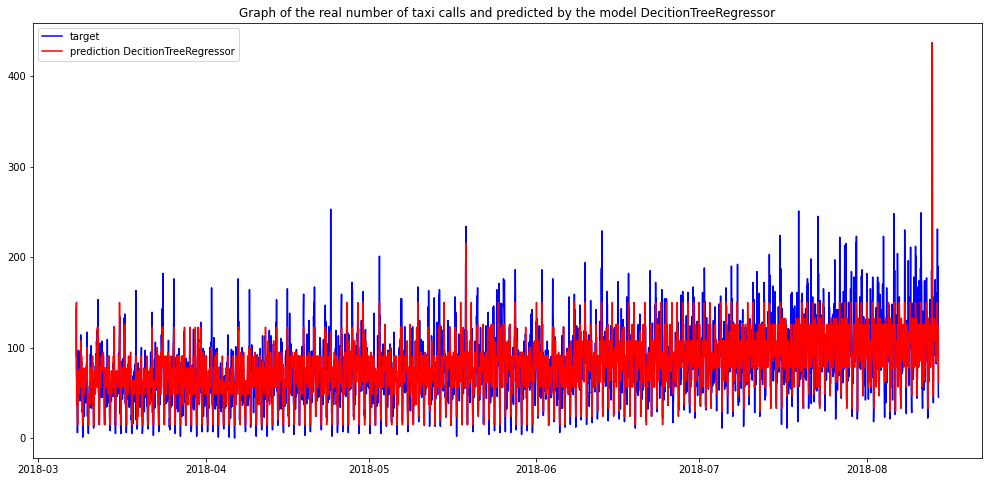

In [25]:
%%time
best_tree = learn_model(tree, df, 'DecitionTreeRegressor')

,Model,Cross-validation RMSE,RMSE train,Train time,Best Model
1,LinearRegressor,-765.8,26.08,0.01,LinearRegression()


Wall time: 156 ms


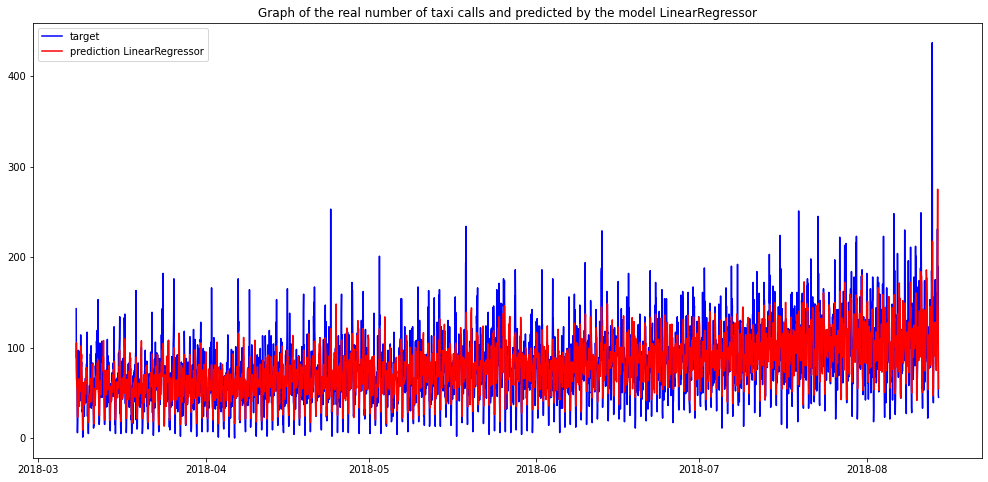

In [26]:
%%time
best_line = learn_model(line,  df, 'LinearRegressor')

,Model,Cross-validation RMSE,RMSE train,Train time,Best Model
2,GradientBoostingRegressor,-758.76,17.42,1.75,([DecisionTreeRegressor(criterion='friedman_ms...


Wall time: 8.39 s


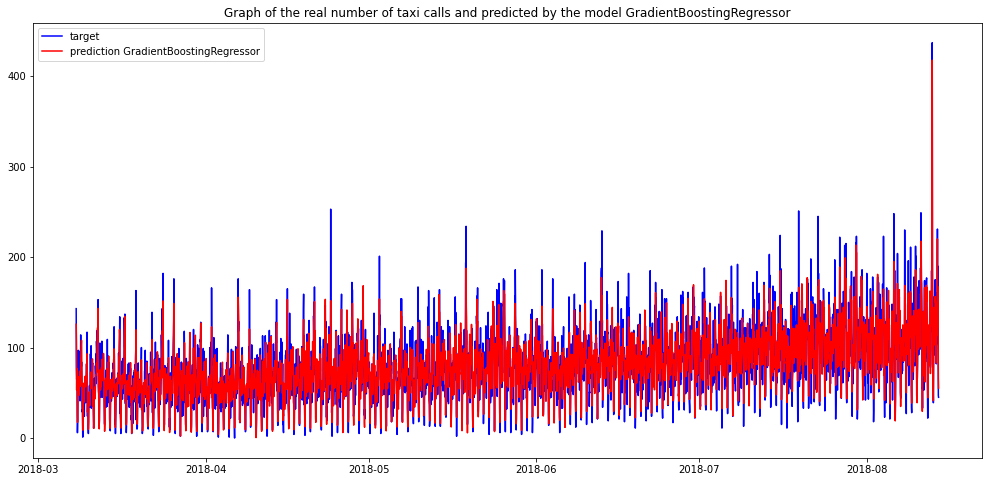

In [27]:
%%time
best_gb = learn_model(gb, df, 'GradientBoostingRegressor')

,Model,Cross-validation RMSE,RMSE train,Train time,Best Model
3,XGBRegressor,-717.83,11.86,0.49,"XGBRegressor(base_score=None, booster=None, ca..."


Wall time: 2.74 s


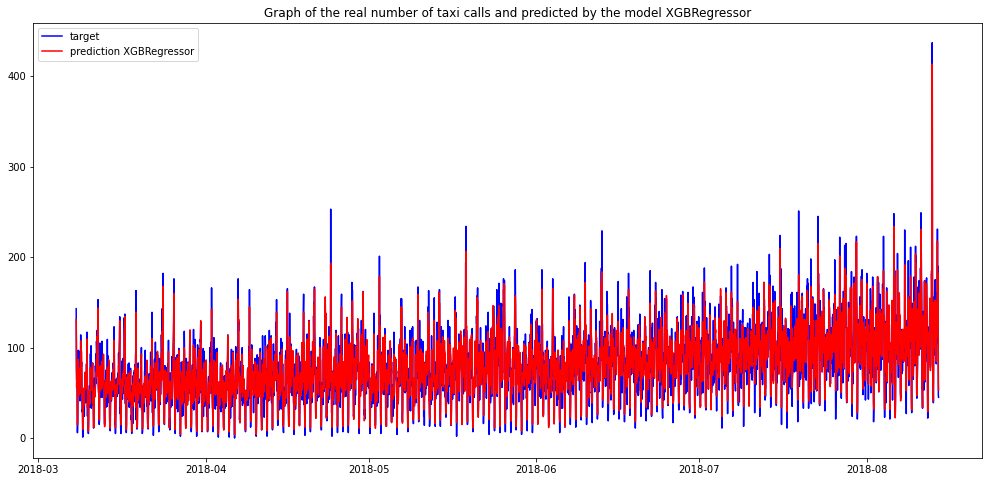

In [28]:
%%time
best_xgbr = learn_model(xgbr, df, 'XGBRegressor')

,Model,Cross-validation RMSE,RMSE train,Train time,Best Model
4,CatBoostRegressor,-681.47,12.7,37.11,<catboost.core.CatBoostRegressor object at 0x0...


Wall time: 4min 14s


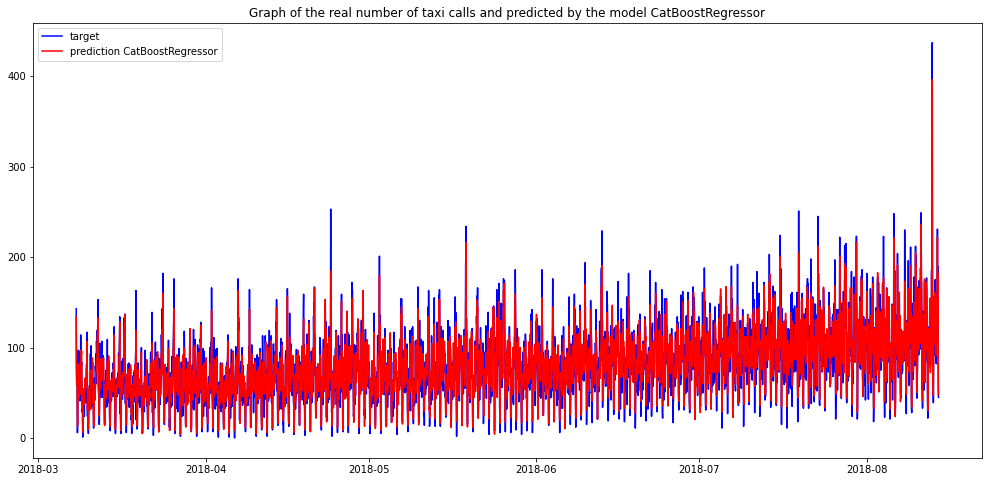

In [29]:
%%time
best_cat = learn_cat_model(cat, df,'CatBoostRegressor')

,Model,Cross-validation RMSE,RMSE train,Train time,Best Model
5,LGBMRegressor,-729.08,22.19,0.04,"LGBMRegressor(learning_rate=0.25, num_leaves=3..."


Wall time: 43.2 s


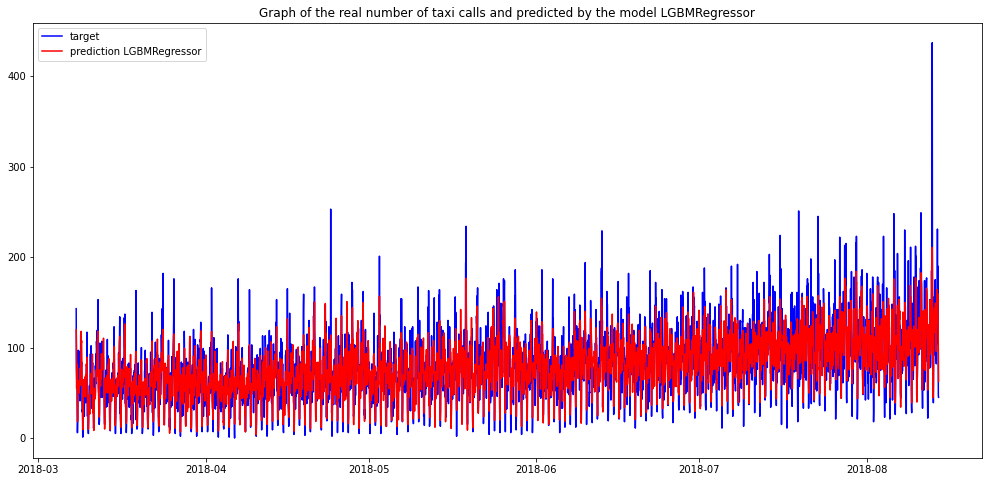

In [30]:
%%time
best_lgbr = learn_lgbm_model(lgbr, df,'LGBMRegressor',params=lgb_params)

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
    
<b> And the winner is:</b>
    
</div>

In [31]:
results.loc[:,:'Train time'].sort_values(by = 'RMSE train', ascending = True)

,Model,Cross-validation RMSE,RMSE train,Train time
3,XGBRegressor,-717.83,11.86,0.49
4,CatBoostRegressor,-681.47,12.70,37.11
2,GradientBoostingRegressor,-758.76,17.42,1.75
5,LGBMRegressor,-729.08,22.19,0.04
0,DecitionTreeRegressor,-966.45,25.44,0.04
1,LinearRegressor,-765.80,26.08,0.01


## Testing

In [33]:
def final_test(model):
    final_df = make_features(df, max_lag, rolling_mean_size) 
    features_train,features_test,target_train,target_test = make_train_n_test(final_df)

    prediction = model['Best Model'].predict(features_test)
    print(f'RMSE: {rmse(target_test,prediction)}')
    print(f'Difference: {(target_test-prediction).mean()}')

    plt.figure(figsize=(17,8))
    plt.plot(features_test.index, target_test, 'b-', 
             features_test.index, prediction, 'r-')
    labels = ['target', f'prediction {model["Model"]}']
    plt.legend(labels)
    plt.title(f'Graph of the real number of taxi calls and predicted by the model {model["Model"]}')
    plt.show

Best Model:  XGBRegressor
RMSE: 44.709026648757934
Difference: 11.902855233585134


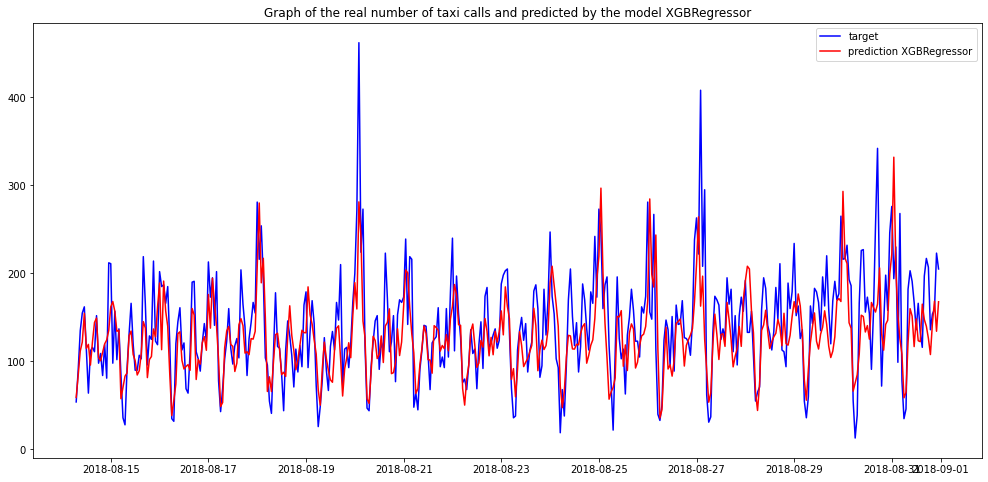

In [34]:
sort_model = results.sort_values(by = 'RMSE train', ascending = True).reset_index()
print('Best Model: ',sort_model.loc[0]['Model'])
final_test(sort_model.loc[0])

## SARIMAX

Dickey-Fuller test: p=0.000732


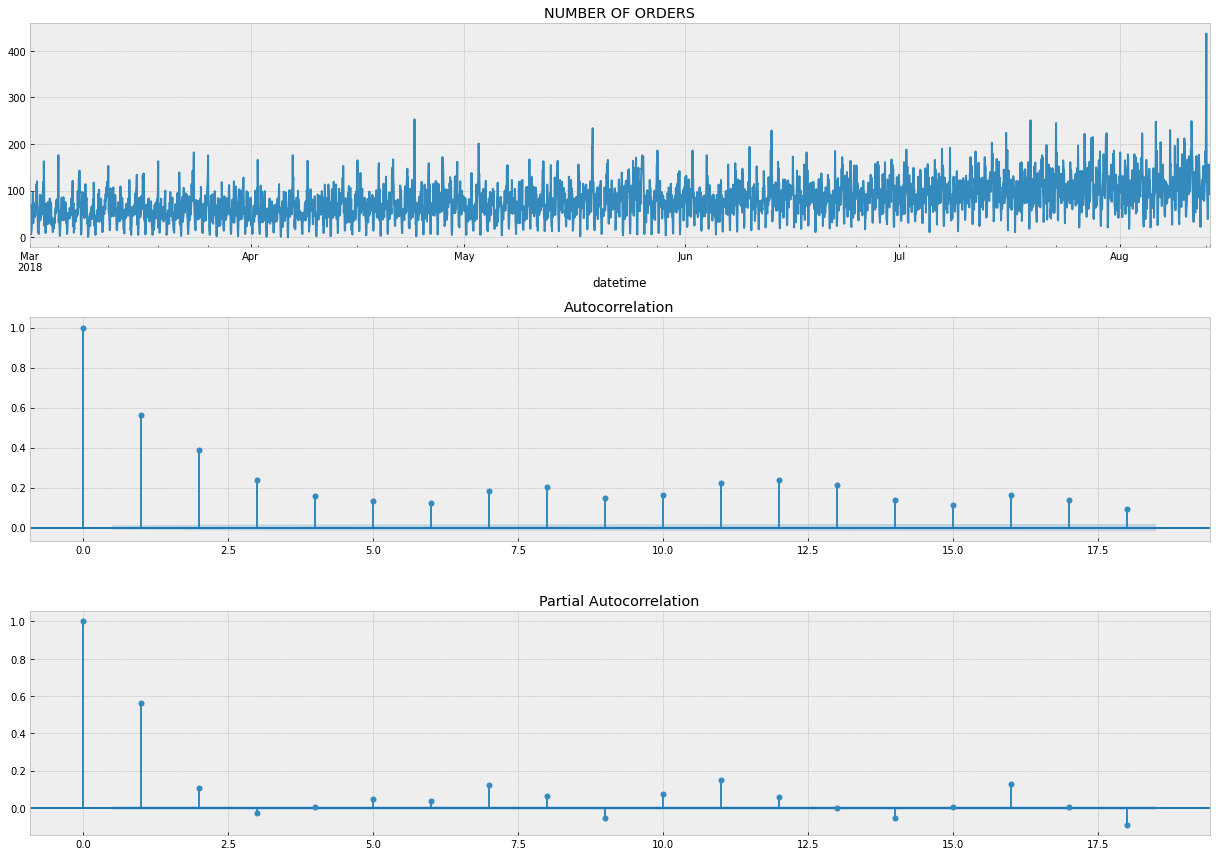

In [35]:
def tsplot(y, lags=None, figsize=(17, 12), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (2, 0))

        y.plot(ax=ts_ax)
        ts_ax.set_title('NUMBER OF ORDERS')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

def train_test_splits(data):
    train,test = train_test_split(data,shuffle = False, test_size = 0.1)
    return train, test

df_new = df.copy()

train_new, test_new = train_test_splits(df_new)
train_new_copy = train_new.copy()
tsplot(train_new['num_orders'], lags=18)

Dickey-Fuller test: p=0.000594
Optimal parameter of the Box-Cox transformation: 0.605218


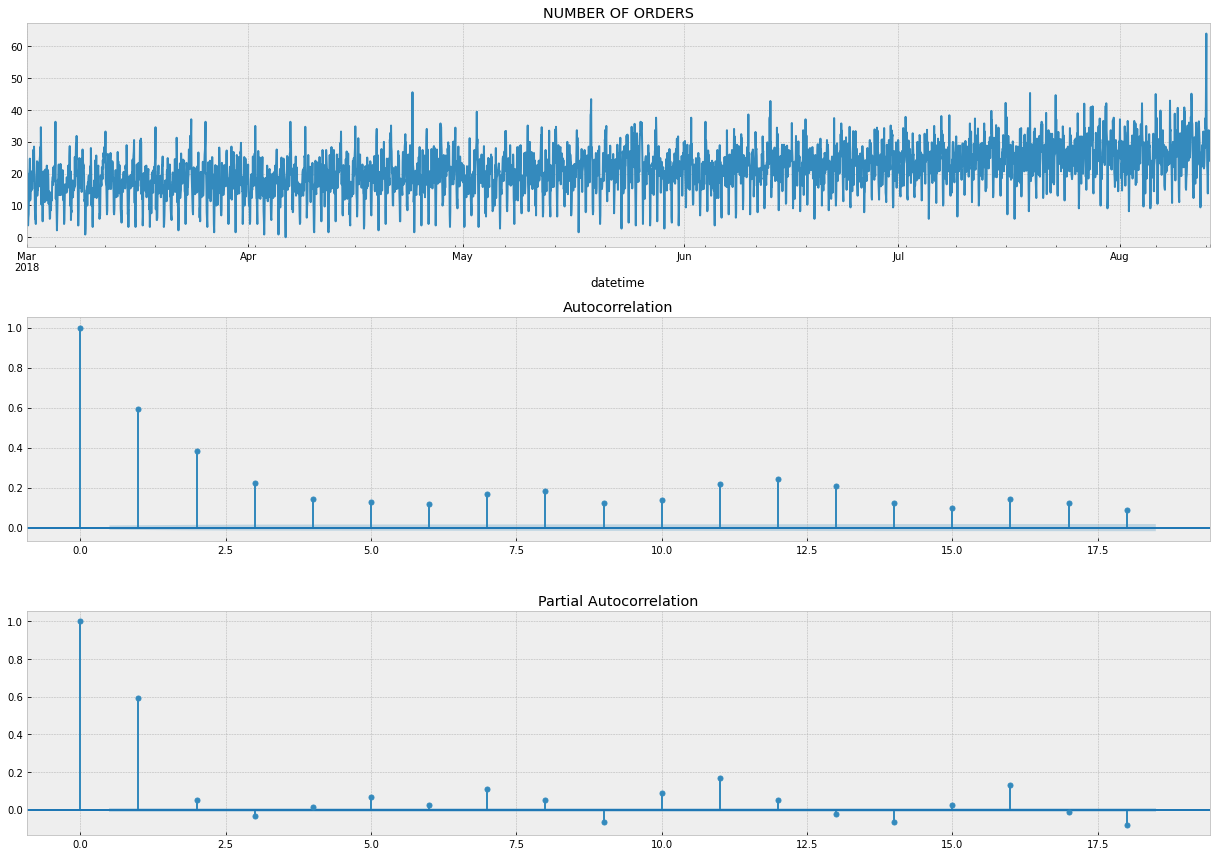

In [36]:
def invboxcox(y,lmbda):
    # inverse Box-Cox transform
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))


train_new_copy['num_orders'], lmbda = scs.boxcox(train_new_copy['num_orders']+1) 
# add one, since there are zeros in the original series
tsplot(train_new_copy['num_orders'], lags=18)
print("Optimal parameter of the Box-Cox transformation: %f" % lmbda)

Dickey-Fuller test: p=0.000000


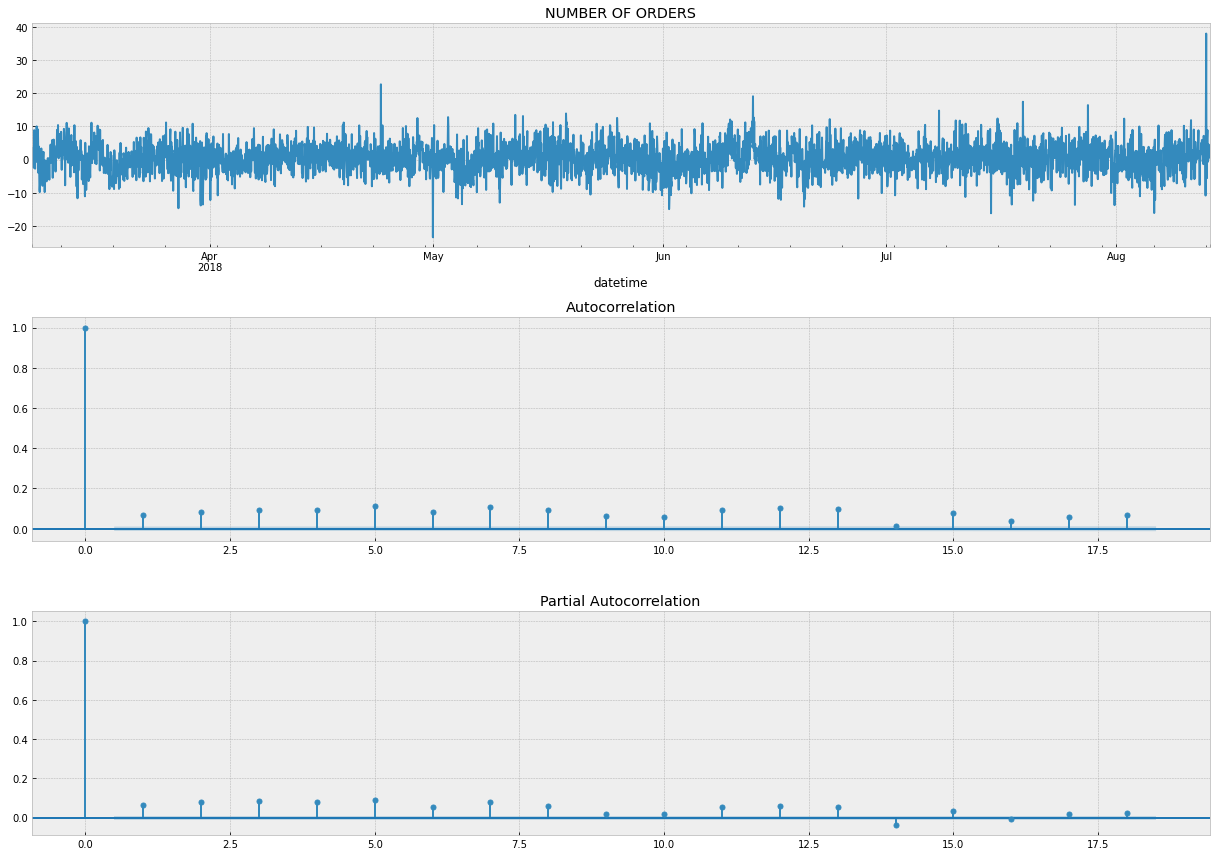

In [37]:
train_new_copy['num_orders_season'] = train_new_copy['num_orders'] - train_new_copy['num_orders'].shift(24*7)
tsplot(train_new_copy['num_orders_season'][24*7:], lags=18)

In [38]:
# series is stationary
d=1
D=1
s=24
best_model = ''
best_aic = float('inf')

params = [(0, 0, 0, 0),
          (1, 1, 1, 1),
          (2, 1, 1, 1)]

In [39]:
%%time

result = []
best_model = 0
best_aic = float('inf')
best_param = 0
for param in tqdm(params):
    try:
        model = sarimax.SARIMAX(train_new['num_orders'], 
                       order=(param[0], d, param[1]), 
                       seasonal_order=(param[2], D, param[3],s)).fit(disp=-1)
        aic = model.aic
        print([param, aic])
        result.append([param, aic])
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
    except:
        print('wrong params', param)
        continue

 33%|████████████████████████████                                                        | 1/3 [00:00<00:00,  2.21it/s]

[(0, 0, 0, 0), 40160.694603258635]


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:39<00:23, 23.22s/it]

[(1, 1, 1, 1), 35679.81558256828]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:31<00:00, 30.61s/it]

[(2, 1, 1, 1), 35665.07187968207]
Wall time: 1min 31s


In [40]:
%%time
print(best_model.summary()) 

                                     SARIMAX Results                                      
Dep. Variable:                         num_orders   No. Observations:                 3974
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -17826.536
Date:                            Mon, 17 Apr 2023   AIC                          35665.072
Time:                                    14:14:58   BIC                          35702.759
Sample:                                03-01-2018   HQIC                         35678.440
                                     - 08-13-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1591      0.013     12.502      0.000       0.134       0.184
ar.L2          0.1063      0.014   

Dickey-Fuller test: p=0.000000


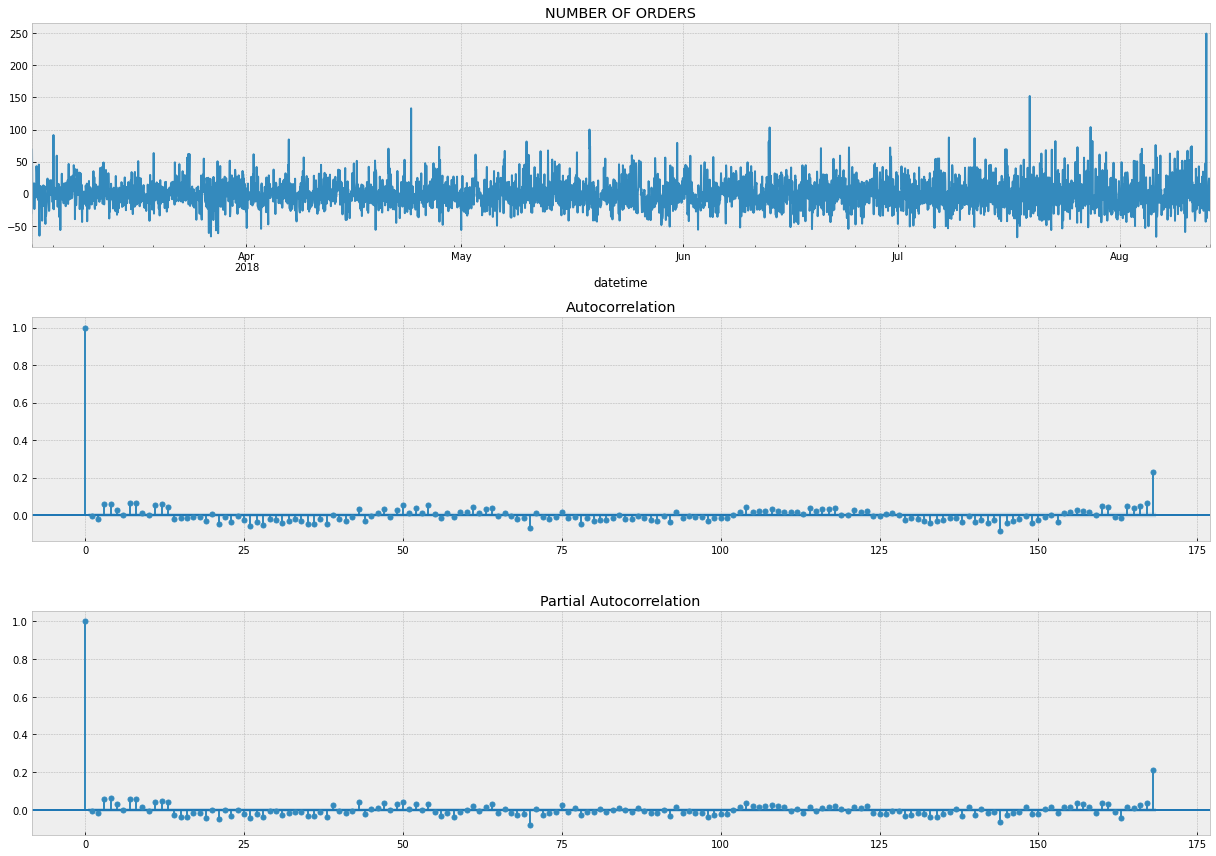

In [41]:
tsplot(best_model.resid[24:], lags=24*7)

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
    
The residuals are stationary, there are no explicit autocorrelations, let's build a forecast using the resulting model.
    
</div>

RMSE of SARIMAX Model: 22.199062846162573
Wall time: 59 ms


<function matplotlib.pyplot.show(close=None, block=None)>

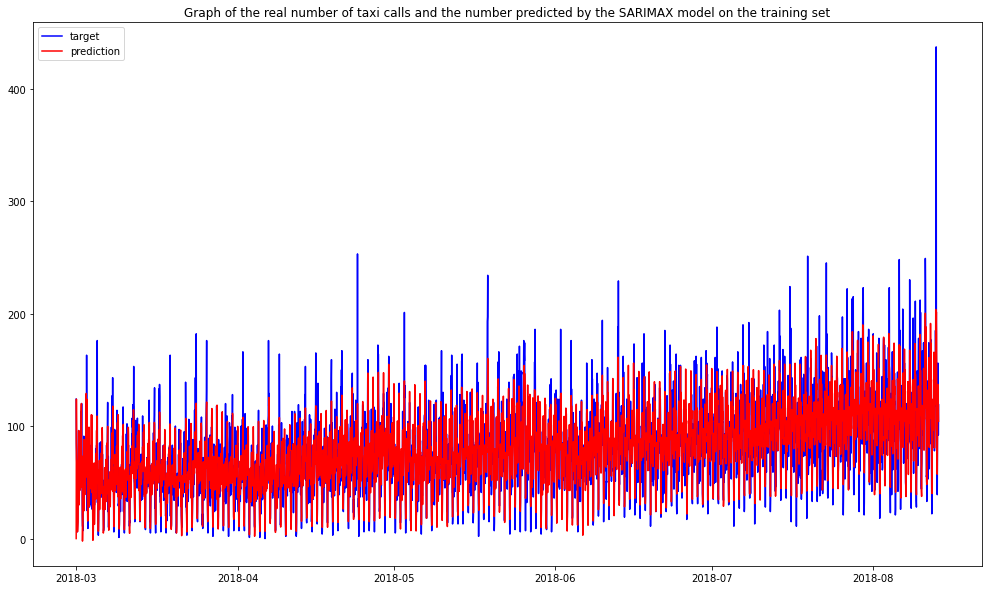

In [42]:
%%time
prediction_date_start = min(train_new.index)
prediction_date_end = max(train_new.index)
prediction = train_new.copy()
prediction['num_orders'] = best_model.predict(start=prediction_date_start,end=prediction_date_end)
best_rmse = rmse(train_new['num_orders'],prediction['num_orders'])
print(f'RMSE of SARIMAX Model: {best_rmse}')

plt.figure(figsize=(17,10))
plt.plot(train_new.index, train_new['num_orders'], 'b-', 
         train_new.index, prediction['num_orders'], 'r-')
labels = ['target', 'prediction']
plt.legend(labels)
plt.title('Graph of the real number of taxi calls and the number predicted by the SARIMAX model on the training set')
plt.show

## SARIMAX TEST

RMSE of SARIMAX Model: 39.33831038496948
Wall time: 95 ms


<function matplotlib.pyplot.show(close=None, block=None)>

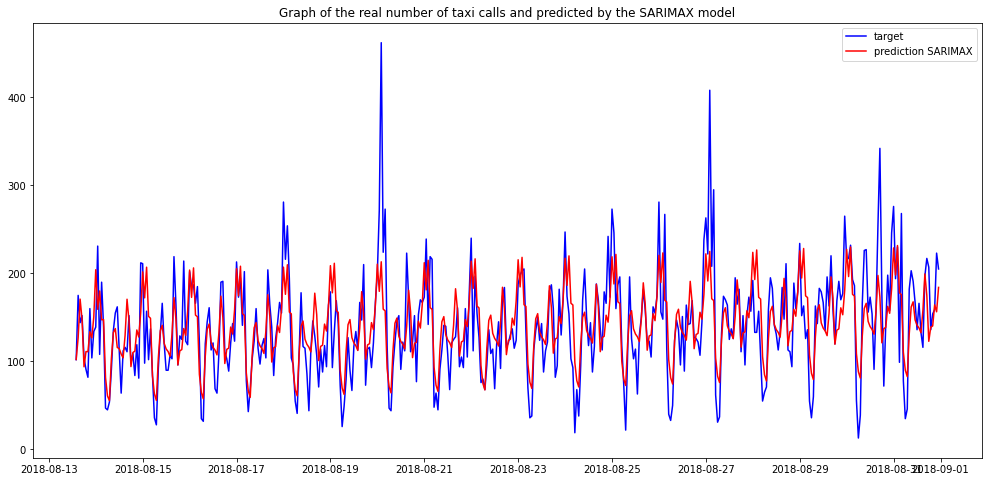

In [43]:
%%time
prediction_date_start = min(test_new.index)
prediction_date_end = max(test_new.index)
prediction = test_new.copy()
prediction['num_orders'] = best_model.predict(start=prediction_date_start,end=prediction_date_end)
best_rmse = rmse(test_new['num_orders'],prediction['num_orders'])
print(f'RMSE of SARIMAX Model: {best_rmse}')

plt.figure(figsize=(17,8))
plt.plot(test_new.index, test_new['num_orders'], 'b-', 
         test_new.index, prediction['num_orders'], 'r-')
labels = ['target', 'prediction SARIMAX']
plt.legend(labels)
plt.title('Graph of the real number of taxi calls and predicted by the SARIMAX model')
plt.show

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
    
### Conclusion

During the project, two successful models were built to predict the number of taxi calls near the airport per hour for the company.
    
*Business challenge:* Learn to attract more drivers during peak periods. At the same time, the root mean square error should not exceed 48 <code>(RMSE < 48)</code>.
                                                                                                                                                  
As a result of data analysis, we found the following:
    
- The data is a time series with historical information on the number of taxi calls from the airport between March and August 2018. Data is recorded every 10 minutes
- There are no gaps or deviations in the data
- After resampling for one hour, it was found that the time series was stationary
- The data has trends and seasonality: depending on the month, day of the week, and time of day.
    
We were faced with the task of regression in which it is necessary to predict a quantitative target metric: the required number of taxis at the airport per hour.

<hr>
    
When preparing data for features, in addition to specifying the month, day, and day of the week, a moving average and shifts were added. Window size = week; due to weekly seasonality, 24 hours were taken as a shift because the daily seasonality is visible in the time series.

    
<hr>
When training regression models, the following RMSE results were obtained:
    
|Model|Cross-validation RMSE|RMSE training|Training time|
|:-:|:-:|:-:|:-:|
|XGBRegressor |-717.83 |11.86 |0.49 |
|CatBoostRegressor| -681.47| 12.70| 37.11 |
|GradientBoostingRegressor|-758.76| 17.42 |1.75 |
|LGBMRegressor| -729.08| 22.19 |0.04|
|DecitionTreeRegressor| -966.45 |25.44| 0.04 |
|LinearRegressor |-765.80 |26.08 |0.01|



Having obtained the best RMSE on the training sample from eXtra Gradient Boosting Regressor, this regressor was chosen.
    
<hr>
    
When tested on a test sample, our best model produced the following graph:
    
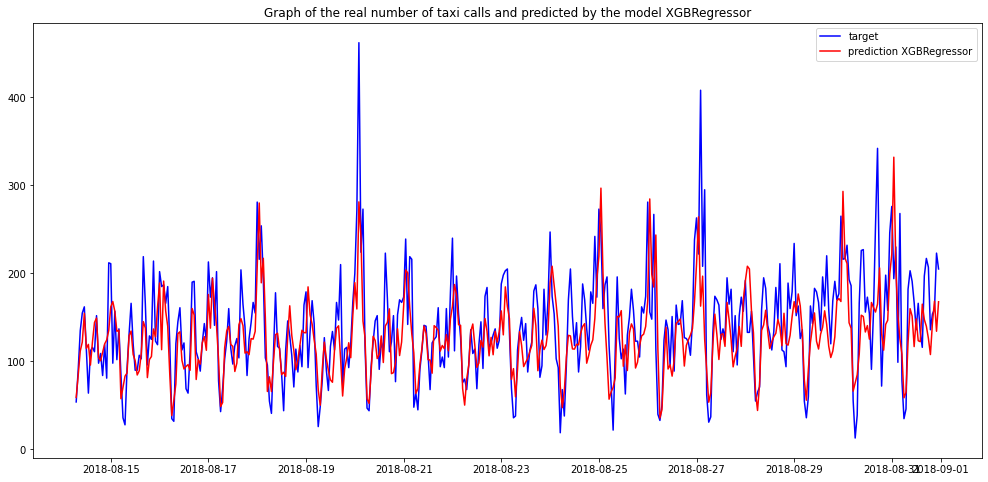
    
The prediction graph shows that the model accurately predicts the overall direction. At the time of an actual increase in activity, the model also goes up and vice versa. The charts are similar.
    
Our regression model could be better at guessing the height of the peaks at the time of the highest load (300-400 calls per hour). Most likely, this is due to seasonality and the schedule of arrivals at the airport. Considering that we predict orders for the period at the end of August and train for a period in which there is no information about trends in August, such errors could arise due to many returning families with children from the summer holidays. Two peaks fall on August 20 and 27 - these are Mondays. Something happened at the airport on Mondays in August 2018; you must read the news and see which flights arrived.
   
<hr>
During the project, the SARIMAX model was additionally applied. On the training set, the model gave RMSE = 22.2, and on the test demonstrated RMSE = 39.3 and presented the following prediction:
    
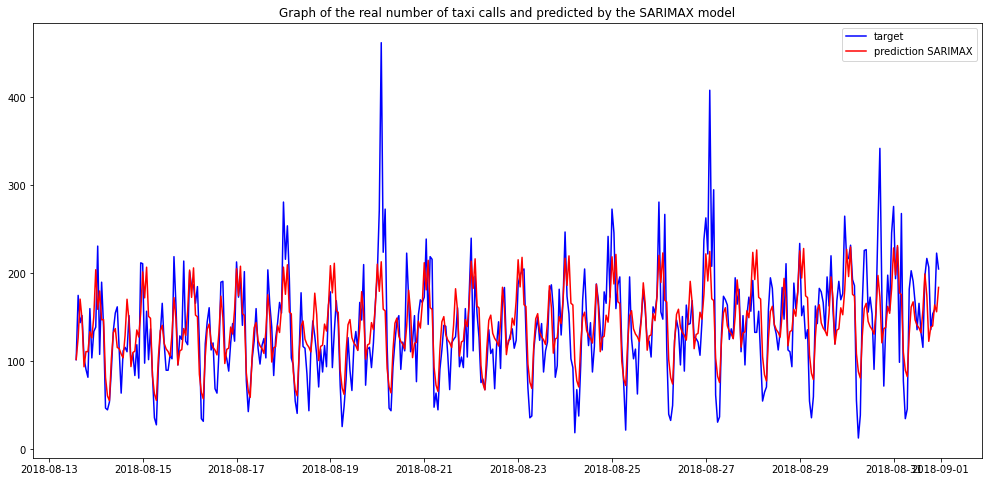
    
This prediction has the same drawbacks as the CatBoostRegressor prediction. But the model behaves boldly at seasonal peaks and builds a higher forecast here.
    
This model is good at predicting data over a short period and does not consider special days and holidays. In essence, it predicts the number of taxis with an upward trend and the same range of changes every 24 hours. Such a model is suitable for time series that do not depend on anomalies. But this is almost impossible to find in real life. 
<hr>
    
We write in the Backlog the following parameters that can improve the predictions:
- Take a more extensive time series
- Find out the number of arriving flights and add them to the data
- Add an indication of holidays, mark holidays in the data
- Add information on traffic jams in the city
- Add the number of taxi drivers who are close to the airport area
- If the taxi service has price indexation, add the value of the coefficient

</div>